## Import Libraries

In [2]:
# Importing the libraries, fill the import name libraries below
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

#Import keras libraries that you need
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error

# EDA

In [46]:
# Some functions to help out with this code
def prediction_plot(test, predicted):
    plt.figure(figsize=(15, 6))
    plt.plot(test, color='red', label='Real Stock Price')
    plt.plot(predicted, color='blue', label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45) 
    plt.legend()
    plt.tight_layout()
    plt.show()

def rmse_eval(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(np.round(rmse, 3)))

In [4]:
# Import Dataset
dataset = pd.read_csv('all_stocks_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date']) #import dataset based on your directory

In [5]:
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93612 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    93587 non-null  float64
 1   High    93602 non-null  float64
 2   Low     93592 non-null  float64
 3   Close   93612 non-null  float64
 4   Volume  93612 non-null  int64  
 5   Name    93612 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 5.0+ MB


In [7]:
dataset.isnull().sum()

Open      25
High      10
Low       20
Close      0
Volume     0
Name       0
dtype: int64

In [8]:
open_mv = round((dataset['Open'].isnull().sum())/len(dataset), 5)
high_mv = round((dataset['High'].isnull().sum())/len(dataset), 5)
low_mv = round((dataset['Low'].isnull().sum())/len(dataset), 5)

In [9]:
print("Missing Value (%)")
print(f"'Open' --> {open_mv} %")
print(f"'High' --> {high_mv} %")
print(f"'Low' --> {low_mv} %")

Missing Value (%)
'Open' --> 0.00027 %
'High' --> 0.00011 %
'Low' --> 0.00021 %


In [10]:
dataset = dataset.dropna()

In [11]:
# Splitting training (2012 - 2016) & test (2017) set
training_set = dataset['2012':'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

C:\Users\marse\AppData\Local\Temp\ipykernel_27616\1044211954.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  training_set = dataset['2012':'2016'].iloc[:,1:2].values
C:\Users\marse\AppData\Local\Temp\ipykernel_27616\1044211954.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  test_set = dataset['2017':].iloc[:,1:2].values


In [12]:
print(f"Training Dataset Shape : {training_set.shape}")
print(f"Test Dataset Shape : {test_set.shape}")

Training Dataset Shape : (38997, 1)
Test Dataset Shape : (7757, 1)


C:\Users\marse\AppData\Local\Temp\ipykernel_27616\3725722439.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset["High"]['2012':'2016'].plot(figsize=(16,4),legend=True)
C:\Users\marse\AppData\Local\Temp\ipykernel_27616\3725722439.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset["High"]['2017':].plot(figsize=(16,4),legend=True)


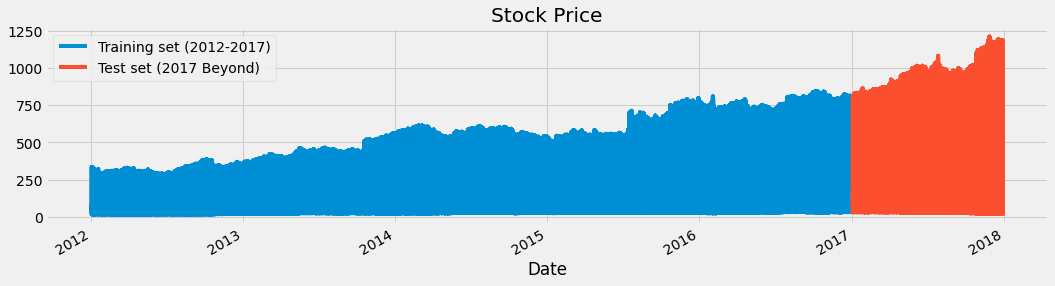

In [13]:
#Checking for stock's market company with line plot
#Write your code below
dataset["High"]['2012':'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (2012-2017)','Test set (2017 Beyond)'])
plt.title('Stock Price')
plt.show()

### EDA Insights
- Terdapat beberapa missing value pada kolom 'Open', 'High', dan 'Low'. Dimana persentase missing value dari masing-masing kolom sebesar sangat kecil. Dikarenakan persentase missing valuenya dibawah 10%, maka row/baris yang memiliki missing value akan didrop.
- Berdasarkan grafik "Stock Price" diatas, dapat dilihat bahwa stock price semakin menaik dengan seiringnya waktu. Jadi seharusnya model yang dibuat akan menghasilkan prediksi yang akan ikut menaik juga.

In [14]:
# Scaling with minmaxscaller for data train
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [15]:
#checking shape of data train
training_set_scaled.shape

(38997, 1)

In [16]:
# create data structure to fill how many row for input in your model at data train
X_train = []
y_train = []
for i in range(60,38997):
    #fill for x_train and y_train here
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
    
#change it into the array
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
# Reshaping X_train before modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

## Modelling

### LSTM

In [18]:
model_lstm = Sequential()

# First LSTM layer with Dropout regularisation
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))

# Second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Third LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Fourth LSTM layer
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))

# The output layer
model_lstm.add(Dense(units=1))

# Compiling the RNN
model_lstm.compile(optimizer='rmsprop',loss='mean_squared_error')

# Fitting to the training set
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
1217/1217 [==============================] - 99s 75ms/step - loss: 0.0013
Epoch 2/50
1217/1217 [==============================] - 93s 76ms/step - loss: 7.5768e-04
Epoch 3/50
1217/1217 [==============================] - 92s 76ms/step - loss: 6.2568e-04
Epoch 4/50
1217/1217 [==============================] - 85s 70ms/step - loss: 5.9710e-04
Epoch 5/50
1217/1217 [==============================] - 86s 70ms/step - loss: 5.2146e-04
Epoch 6/50
1217/1217 [==============================] - 96s 79ms/step - loss: 5.0763e-04
Epoch 7/50
1217/1217 [==============================] - 110s 90ms/step - loss: 4.7803e-04
Epoch 8/50
1217/1217 [==============================] - 110s 91ms/step - loss: 4.4554e-04
Epoch 9/50
1217/1217 [==============================] - 137s 112ms/step - loss: 4.2991e-04
Epoch 10/50
1217/1217 [==============================] - 121s 100ms/step - loss: 4.2450e-04
Epoch 11/50
1217/1217 [==============================] - 104s 85ms/step - loss: 4.1848e-04
Epoch 12/50
1217

#### Prediction

In [32]:
# Prepare for data test similar way for data train
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
test = dataset_total[len(dataset_total)-len(test_set) - 60:].values

#Transform the inputs
inputs = test.reshape(-1,1)
inputs = sc.transform(inputs)

C:\Users\marse\AppData\Local\Temp\ipykernel_27616\1176121625.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)


In [41]:
# Preparing X_test and predicting the prices of the stock's that you choose
X_test = []
for i in range(60, 7817):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Predicting stocks price
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

243/243 [==============================] - 7s 29ms/step


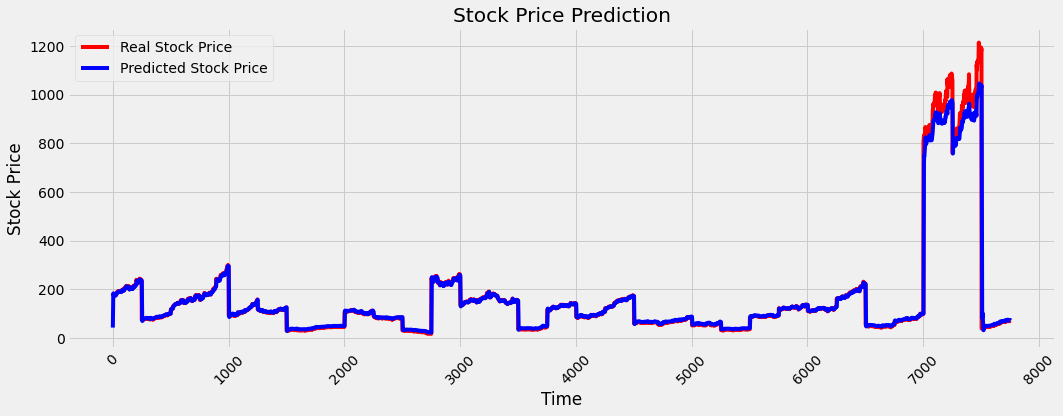

In [42]:
# Visualizing the results for prediction
prediction_plot(test_set, predicted_stock_price)

In [47]:
# Evaluating our model with RMSE function above
rmse_eval(test_set,predicted_stock_price)

The root mean squared error is 28.151.


### GRU

In [58]:
# Sequential Modelling
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))

# Second GRU layer
model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Third GRU layer, fill the code below
model.add(GRU(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

# Fourth GRU layer, fill the code below
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

# Compiling
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')

# Train fitting for the model
model.fit(X_train, y_train, epochs=50, batch_size=150, verbose=1)

Epoch 1/50
260/260 [==============================] - 97s 341ms/step - loss: 0.0064
Epoch 2/50
260/260 [==============================] - 95s 365ms/step - loss: 7.4635e-04
Epoch 3/50
260/260 [==============================] - 97s 372ms/step - loss: 7.3168e-04
Epoch 4/50
260/260 [==============================] - 103s 396ms/step - loss: 6.6788e-04
Epoch 5/50
260/260 [==============================] - 108s 416ms/step - loss: 6.6041e-04
Epoch 6/50
260/260 [==============================] - 97s 372ms/step - loss: 6.5163e-04
Epoch 7/50
260/260 [==============================] - 95s 367ms/step - loss: 6.1702e-04
Epoch 8/50
260/260 [==============================] - 96s 371ms/step - loss: 6.1323e-04
Epoch 9/50
260/260 [==============================] - 95s 366ms/step - loss: 5.8753e-04
Epoch 10/50
260/260 [==============================] - 96s 367ms/step - loss: 6.0014e-04
Epoch 11/50
260/260 [==============================] - 95s 366ms/step - loss: 5.9503e-04
Epoch 12/50
260/260 [===========

In [59]:
# Prepare for data test similar way for data train
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
test = dataset_total[len(dataset_total)-len(test_set) - 60:].values

#Transform the inputs
inputs = test.reshape(-1,1)
inputs = sc.transform(inputs)

C:\Users\marse\AppData\Local\Temp\ipykernel_24916\1176121625.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)


In [67]:
#checking data test shape
inputs.shape 

(7817, 1)

#### Prediction

In [62]:
# Preparing X_test and predicting the prices of the stock's that you choose
X_test = []
for i in range(60, 7817):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#Predicting stocks price
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

243/243 [==============================] - 9s 29ms/step


In [63]:
(predicted_stock_price)

array([[42.278294],
       [49.58207 ],
       [65.009224],
       ...,
       [74.45647 ],
       [74.51107 ],
       [74.472595]], dtype=float32)

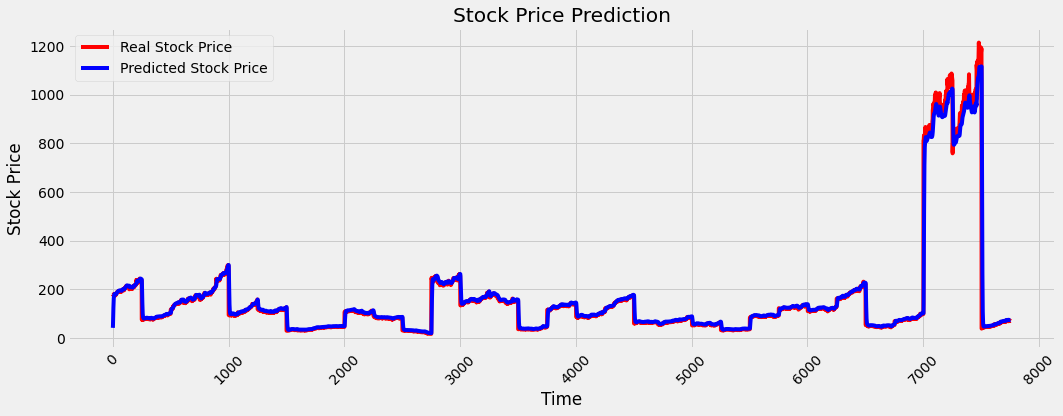

In [174]:
# Visualizing the results for prediction
prediction_plot(test_set, predicted_stock_price)

In [65]:
# Evaluating our model with RMSE function above
rmse_eval(test_set,predicted_stock_price)

The root mean squared error is 33.36028414130687.


### Insight and advice

<b>Insight</b> :
- Berdasarkan kedua model yang dibuat, yaitu LSTM dan GRU. Bahwa nilai RMSE yang lebih kecil adalah model LSTM, yaitu dengan RMSE sebesar 28.15 %. Sedangkan model GRU sebesar 33.36 %.

- Lalu pada akhir-akhir tahun 2017, prediksi & aktual value stock price merupakan value yang sedang klimaks atau tinggi-tingginya. Walaupun sisanya (pada bulan-bulan lainnya), value aktual & prediksinya sangat jauh perbandingannya dari stock price yang sedang klimaks tersebut.

<b>Advice</b> :

Berdasarkan kedua model yang dibuat, model LSTM merupakan yang terkecil nilai RMSE-nya yaitu sebesar 28.15 %. Jadi model ini yang bisa dideploy atau digunakan. 

Walaupun sebenarnya menurut saya agak besar untuk nilai RMSE-nya. Oleh karena itu, model tersebut harus dibuatkan hyperparameter tuning lagi, supaya mendapatkan parameter dengan value yang cocok dan RMSE yang lebih kecil lagi.